# Tools for extracting NIRSpec spectra from 2D cutouts

*msaexp code and notebook by Gabe Brammer with small additions by Dan Coe*

0. Query MAST for data
1. Run the preprocessing pipline through extracting 2D cutouts
1. Drizzle the cutouts to a combined spectrum
1. Extract 1D spectrum
1. Fit redshift

Gabe Brammer's example notebooks analyzing NIRSpec MSA data with msaexp:  
https://github.com/gbrammer/msaexp

from Dan Coe's GO 1433:  
https://github.com/gbrammer/msaexp/blob/main/docs/examples/drizzled-nirspec.ipynb

from Pat Kelly's DD 2756:  
https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-rxj2129.ipynb

from the ERO SMACS0723:  
https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb

In [1]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)
else:
    print('(not on a codespace)')

(not on a codespace)


In [2]:
import os
import glob
import yaml
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
from jwst.datamodels import SlitModel


import msaexp
from msaexp import pipeline
import msaexp.drizzle
#reload(msaexp.drizzle)
#reload(msaexp.utils)

print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')
print(f'matplotlib version = {matplotlib.__version__}')

grizli version = 1.7.5
msaexp version = 0.6.0
matplotlib version = 3.7.0


In [3]:
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

## Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [4]:
# MACS0647-JD, GO-1433 Coe et al.
#os.chdir('/Users/gbrammer/Research/JWST/Projects/NIRSpec/j0647/')
prog = 1433
#outroot = 'macsj0647'
outroot = 'macs0647'
file_version = 'v1'
os.getcwd()

'/Users/dcoe/macs0647/MSA/dataObs21'

In [5]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(prog, download=True)

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [6]:
files = glob.glob(f'jw0{prog}*rate.fits')

groups = pipeline.exposure_groups(files=files)

print('\nFiles:\n======')
print(yaml.dump(dict(groups)))

   N  value     
====  ==========
   1  jw01433021001-01-clear-prism-nrs1
   1  jw01433021001-01-clear-prism-nrs2
   1  jw01433021001-02-clear-prism-nrs1
   1  jw01433021001-02-clear-prism-nrs2
   3  jw01433023001-01-clear-prism-nrs1
   3  jw01433023001-01-clear-prism-nrs2

Files:
jw01433021001-01-clear-prism-nrs1:
- jw01433021001_03101_00001_nrs1_rate.fits
jw01433021001-01-clear-prism-nrs2:
- jw01433021001_03101_00001_nrs2_rate.fits
jw01433021001-02-clear-prism-nrs1:
- jw01433021001_05101_00001_nrs1_rate.fits
jw01433021001-02-clear-prism-nrs2:
- jw01433021001_05101_00001_nrs2_rate.fits
jw01433023001-01-clear-prism-nrs1:
- jw01433023001_04101_00002_nrs1_rate.fits
- jw01433023001_04101_00003_nrs1_rate.fits
- jw01433023001_04101_00001_nrs1_rate.fits
jw01433023001-01-clear-prism-nrs2:
- jw01433023001_04101_00001_nrs2_rate.fits
- jw01433023001_04101_00002_nrs2_rate.fits
- jw01433023001_04101_00003_nrs2_rate.fits



In [7]:
observation = '21001'
detector = 'nrs2'

## Preprocessing pipeline

`NirspecPipeline`

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

## Extracted spectra 

The end products of the preprocessing pipeline are 2D calibrated spectra ([jwst.datamodels.SlitModel](https://jwst-pipeline.readthedocs.io/en/stable/api/jwst.datamodels.SlitModel.html)) for each slitlet.

In [8]:
def extract_2d_spectrum(target, observation='21001', detector='nrs2'):
    # Set slit files
    #exposure_files = select_files(list(groups), ['21001', 'nrs2'])
    exposure_files = select_files(list(groups), [observation, detector])
    slit_files = []

    for exposure_file in exposure_files:
        pipe = pipeline.NirspecPipeline(mode=exposure_file, pad=1)
        for file in pipe.files:
            slit_files.extend(glob.glob(f"{file.split('nrs')[0]}*phot*{target}*fits"))

    slit_files.sort()     
    show_slits = len(slit_files) > 1

    # Drizzle combine
    _ = msaexp.drizzle.drizzle_slitlets(target,
                                        output=outroot,
                                        files=slit_files[:],
                                        center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                        fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                        force_nypix=31,         # Y size of output array
                                        bkg_offset=6,           # Number of pixels to roll for background subtraction
                                        bkg_parity=[-1,1],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                        log_step=False,         # Log wavelength steps
                                        outlier_threshold=10,   # Outlier rejection threshold
                                        err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                        show_drizzled=True,     # Figures
                                        show_slits=show_slits,
                                        imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                        sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                        bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                       )

    figs, hdu_data, wavedata, all_slits, drz_data = _

    return _

In [15]:
def extract_1d_spectrum(hdul, science_target, background_target=None, z=None):
    if background_target:
        outspecroot = f'{outroot}_{science_target}-{background_target}.{file_version}'
    else:
        outspecroot = f'{outroot}_{science_target}.{file_version}'
        
    print(outspecroot)

    outhdu = msaexp.drizzle.extract_from_hdul(hdul, prf_sigma=0.9, fix_sigma=False, prf_center=None, fix_center=False, 
                                              verbose=True)

    outhdu.writeto(outspecroot+'.spec.fits', overwrite=True)
    
    if z:
        outspecroot += '_z%g' % z

    for flux_unit in 'fnu flam'.split():
        fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit=flux_unit, z=z)
        fig.savefig(outspecroot+'.'+flux_unit+'.png')
        
    return outhdu, outspecroot

# JD1 – background

In [10]:
science_target = '3593'  # JD1
background_target = '50981'  # background in both exposures

# (2023-04-03 18:19:37.424)
msaexp.NirspecPipeline: Initialize jw01433021001-01-clear-prism-nrs2
msaexp.NirspecPipeline: jw01433021001_03101_00001_nrs2_rate.fits
# (2023-04-03 18:19:37.886)
msaexp.utils.pad_msa_metafile: Trim jw01433021001_01_msa.fits to [2883, 2901, 2914, 2965, 2992, 3088, 3089, 3097, 3184, 3208, 3258, 3260, 3308, 3349, 3370, 3379, 3414, 3457, 3466, 3493, 3501, 3502, 3593, 3598, 3621, 3622, 3634, 3642, 3723, 3737, 3746, 3754, 3755, 3777, 3778, 3804, 3826, 3901, 3975, 3989, 4111, 4124, 4142, 4238, 4248, 4276, 4298, 4323, 4408, 4455, 4494, 4522, 4554, 4622, 4681, 4719, 4747, 4933, 4945, 4962, 5048, 5082, 5089, 5121, 5271, 5397, 5408, 50820, 50821, 50938, 50939, 50942, 50976, 50978, 50981, 50983, 51009, 51015, 51067, 51085, 51088, 51089, 51102, 51104, 51122, 51131, 51161, 51169, 51170, 51180, 51190, 51191, 51208, 51209, 51212, 51225, 51233, 51243, 51248, 51251, 51288, 51290, 51305, 51313, 51314, 51328, 51330, 51345, 51348, 51349, 51356, 51368, 51385, 51388, 51393, 51394,

2023-04-03 14:19:46,456 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


xxx init  19260 25668 12834


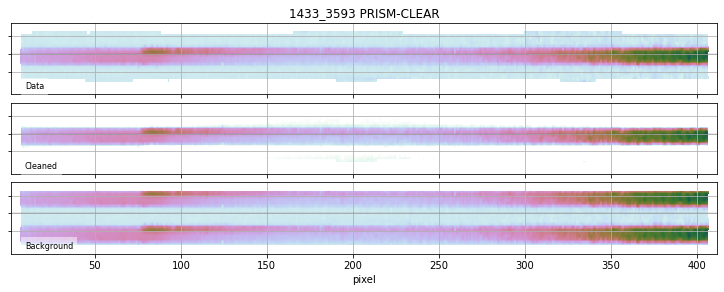

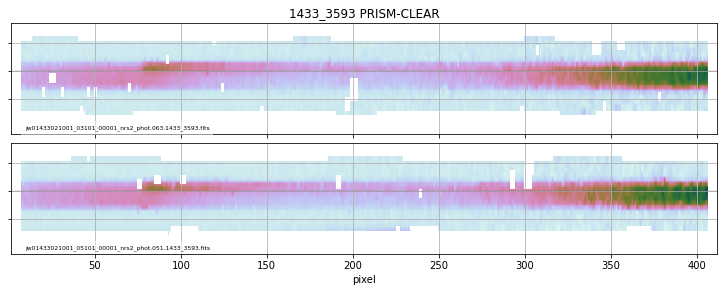

In [11]:
science_spectrum = extract_2d_spectrum(science_target, observation, detector)

# (2023-04-03 18:19:47.186)
msaexp.NirspecPipeline: Initialize jw01433021001-01-clear-prism-nrs2
msaexp.NirspecPipeline: jw01433021001_03101_00001_nrs2_rate.fits
# (2023-04-03 18:19:47.593)
msaexp.utils.pad_msa_metafile: Trim jw01433021001_01_msa.fits to [2883, 2901, 2914, 2965, 2992, 3088, 3089, 3097, 3184, 3208, 3258, 3260, 3308, 3349, 3370, 3379, 3414, 3457, 3466, 3493, 3501, 3502, 3593, 3598, 3621, 3622, 3634, 3642, 3723, 3737, 3746, 3754, 3755, 3777, 3778, 3804, 3826, 3901, 3975, 3989, 4111, 4124, 4142, 4238, 4248, 4276, 4298, 4323, 4408, 4455, 4494, 4522, 4554, 4622, 4681, 4719, 4747, 4933, 4945, 4962, 5048, 5082, 5089, 5121, 5271, 5397, 5408, 50820, 50821, 50938, 50939, 50942, 50976, 50978, 50981, 50983, 51009, 51015, 51067, 51085, 51088, 51089, 51102, 51104, 51122, 51131, 51161, 51169, 51170, 51180, 51190, 51191, 51208, 51209, 51212, 51225, 51233, 51243, 51248, 51251, 51288, 51290, 51305, 51313, 51314, 51328, 51330, 51345, 51348, 51349, 51356, 51368, 51385, 51388, 51393, 51394,

2023-04-03 14:19:55,843 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


xxx init  19235 25668 12834


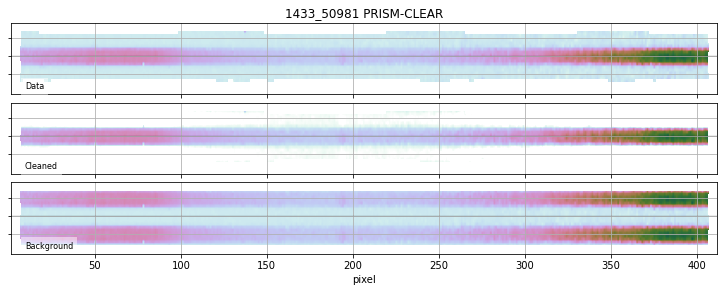

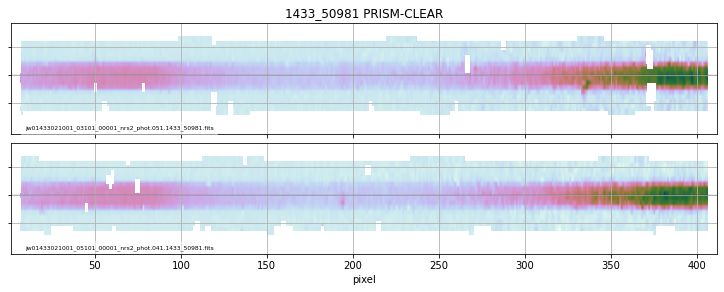

In [12]:
background_spectrum = extract_2d_spectrum(background_target, observation, detector)

macs0647_3593-50981.v1
msaexp.drizzle.extract_from_hdul: Initial center =   0.59, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   2.39, sigma =   0.84


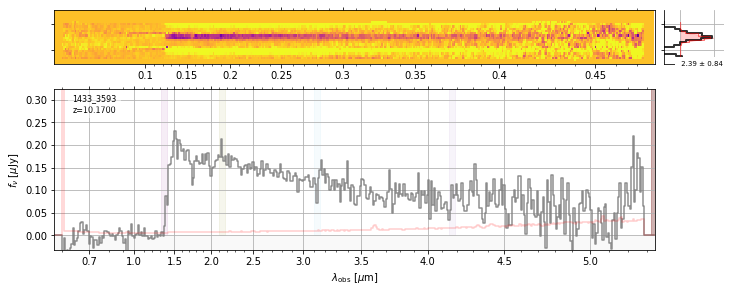

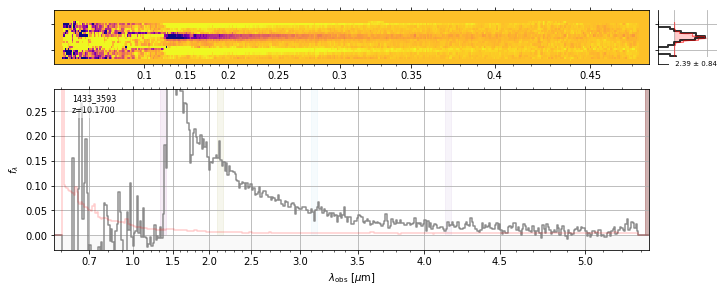

In [14]:
figs, hdu_data, wavedata, all_slits, drz_data = science_spectrum
hdul = hdu_data['prism-clear']

figs, hdu_data, wavedata, all_slits, drz_data = background_spectrum
hdul_background = hdu_data['prism-clear']

# Subtract 2D background
hdul['SCI'].data -= hdul_background['SCI'].data
hdul['BKG'].data -= hdul_background['BKG'].data

_ = extract_1d_spectrum(hdul, science_target, background_target, z=10.17)

# JD2 – background

# (2023-04-03 18:23:10.053)
msaexp.NirspecPipeline: Initialize jw01433021001-01-clear-prism-nrs2
msaexp.NirspecPipeline: jw01433021001_03101_00001_nrs2_rate.fits
# (2023-04-03 18:23:10.499)
msaexp.utils.pad_msa_metafile: Trim jw01433021001_01_msa.fits to [2883, 2901, 2914, 2965, 2992, 3088, 3089, 3097, 3184, 3208, 3258, 3260, 3308, 3349, 3370, 3379, 3414, 3457, 3466, 3493, 3501, 3502, 3593, 3598, 3621, 3622, 3634, 3642, 3723, 3737, 3746, 3754, 3755, 3777, 3778, 3804, 3826, 3901, 3975, 3989, 4111, 4124, 4142, 4238, 4248, 4276, 4298, 4323, 4408, 4455, 4494, 4522, 4554, 4622, 4681, 4719, 4747, 4933, 4945, 4962, 5048, 5082, 5089, 5121, 5271, 5397, 5408, 50820, 50821, 50938, 50939, 50942, 50976, 50978, 50981, 50983, 51009, 51015, 51067, 51085, 51088, 51089, 51102, 51104, 51122, 51131, 51161, 51169, 51170, 51180, 51190, 51191, 51208, 51209, 51212, 51225, 51233, 51243, 51248, 51251, 51288, 51290, 51305, 51313, 51314, 51328, 51330, 51345, 51348, 51349, 51356, 51368, 51385, 51388, 51393, 51394,

2023-04-03 14:23:18,624 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


xxx init  19286 25668 12834


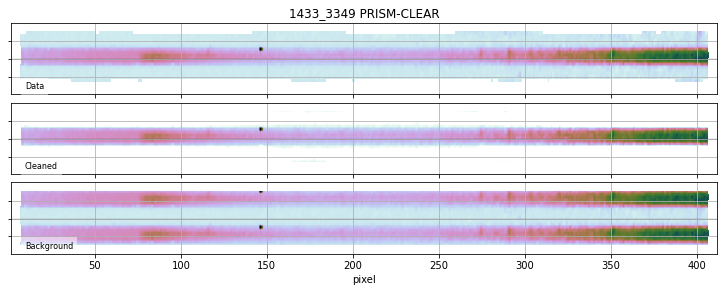

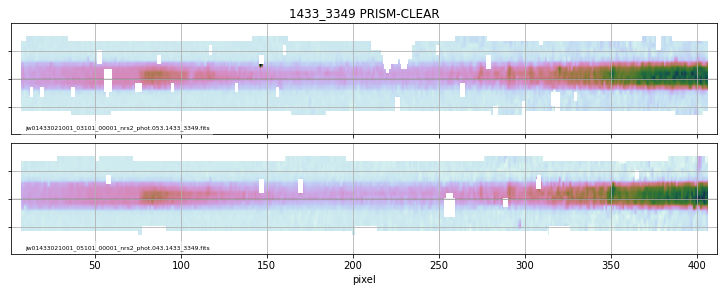

In [16]:
science_target = '3349'  # JD2
science_spectrum = extract_2d_spectrum(science_target, observation, detector)
figs, hdu_data, wavedata, all_slits, drz_data = science_spectrum
hdul = hdu_data['prism-clear']

macs0647_3349-50981.v1
msaexp.drizzle.extract_from_hdul: Initial center =  -1.16, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   0.91, sigma =   1.20


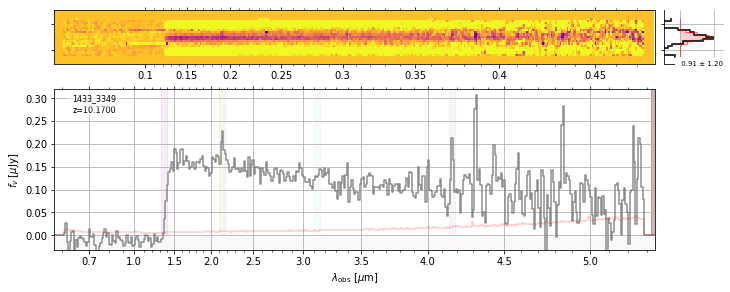

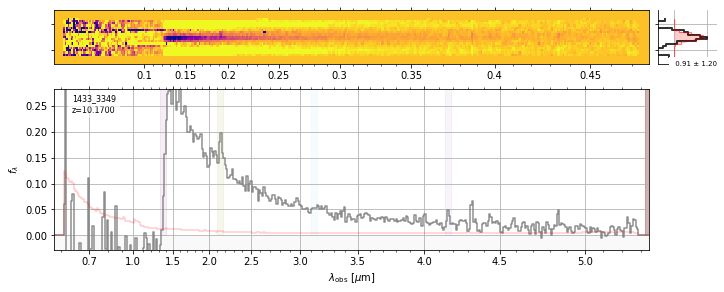

In [17]:
# Subtract 2D background
hdul['SCI'].data -= hdul_background['SCI'].data
hdul['BKG'].data -= hdul_background['BKG'].data

_ = extract_1d_spectrum(hdul, science_target, background_target, z=10.17)

# JDc – background

# (2023-04-03 18:28:35.656)
msaexp.NirspecPipeline: Initialize jw01433021001-01-clear-prism-nrs2
msaexp.NirspecPipeline: jw01433021001_03101_00001_nrs2_rate.fits
# (2023-04-03 18:28:36.090)
msaexp.utils.pad_msa_metafile: Trim jw01433021001_01_msa.fits to [2883, 2901, 2914, 2965, 2992, 3088, 3089, 3097, 3184, 3208, 3258, 3260, 3308, 3349, 3370, 3379, 3414, 3457, 3466, 3493, 3501, 3502, 3593, 3598, 3621, 3622, 3634, 3642, 3723, 3737, 3746, 3754, 3755, 3777, 3778, 3804, 3826, 3901, 3975, 3989, 4111, 4124, 4142, 4238, 4248, 4276, 4298, 4323, 4408, 4455, 4494, 4522, 4554, 4622, 4681, 4719, 4747, 4933, 4945, 4962, 5048, 5082, 5089, 5121, 5271, 5397, 5408, 50820, 50821, 50938, 50939, 50942, 50976, 50978, 50981, 50983, 51009, 51015, 51067, 51085, 51088, 51089, 51102, 51104, 51122, 51131, 51161, 51169, 51170, 51180, 51190, 51191, 51208, 51209, 51212, 51225, 51233, 51243, 51248, 51251, 51288, 51290, 51305, 51313, 51314, 51328, 51330, 51345, 51348, 51349, 51356, 51368, 51385, 51388, 51393, 51394,

2023-04-03 14:28:44,181 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


xxx init  19247 25668 12834


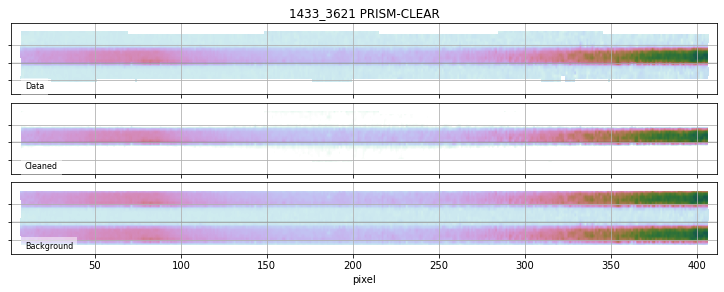

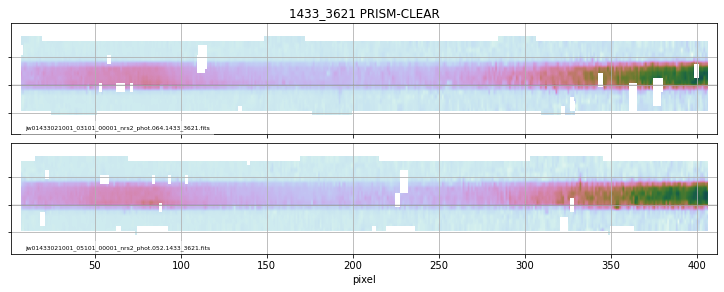

In [18]:
science_target = '3621'  # JDc
science_spectrum = extract_2d_spectrum(science_target, observation, detector)
figs, hdu_data, wavedata, all_slits, drz_data = science_spectrum
hdul = hdu_data['prism-clear']

macs0647_3621-50981.v1
msaexp.drizzle.extract_from_hdul: Initial center =  -2.37, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -0.56, sigma =   0.98


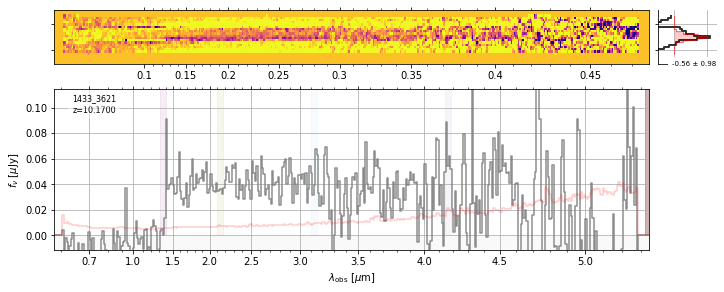

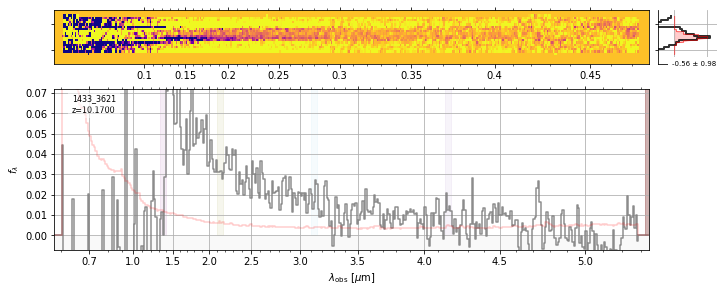

In [19]:
# Subtract 2D background
hdul['SCI'].data -= hdul_background['SCI'].data
hdul['BKG'].data -= hdul_background['BKG'].data

_ = extract_1d_spectrum(hdul, science_target, background_target, z=10.17)